# Laboratorio 4
- Daniel Alfredo Rayo Roldán
- Andre Yatmian Jo
- Flavio André Galán Donis

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.animation import FuncAnimation
import time
import copy

### Parámetros globales

In [64]:
N = 100
MAX_ITER = 100
SELECTION_PERCENTAGE = 0.3
KEEP_PERFORMANCE_PERCENTAGE = 0.1
MUTATION_PERCENTAGE = 0.3
CROSSOVER_PERCENTAGE = 0.6

### Cargado de datos

In [ ]:
# TODO: Andre cambia esto por tus funciones y guardalo en esta variable

ADJACENCY_MATRIX = np.array([
    [1.0, 100, 100, 100, 100],
    [100, 1.0, 100, 100, 100],
    [100, 100, 1.0, 100, 100],
    [100, 100, 100, 1.0, 100],
    [100, 100, 100, 100, 1.0]
])

# ============= CITY COORDINATES =============
CITIES_COORDINATES = np.array([
    [1.0, 1.0],
    [3.0, 1.5],
    [2.0, 0.0],
    [3.5, 3.0],
    [0.5, 3.5]
])

In [58]:
NUM_CITIES = len(ADJACENCY_MATRIX)

## Algoritmos de genético

In [59]:
def calculate_route_distance(route, adj_matrix):
    distance = 0
    for i in range(len(route)):
        from_city = route[i]
        to_city = route[(i + 1) % len(route)]
        distance += adj_matrix[from_city][to_city]
    return distance

def create_random_route():
    route = list(range(NUM_CITIES))
    random.shuffle(route)
    return route

In [60]:
def plot_tsp_convergence(best_distances_history, best_route, cities_coordinates):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_distances_history)
    plt.title('Algorithm Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Best Distance')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.title(f'Best Route (Distance: {best_distances_history[-1]:.2f})')
    
    x_coords = cities_coordinates[:, 0]
    y_coords = cities_coordinates[:, 1]
    
    route_x = [x_coords[city] for city in best_route] + [x_coords[best_route[0]]]
    route_y = [y_coords[city] for city in best_route] + [y_coords[best_route[0]]]
    
    plt.plot(route_x, route_y, 'b-', alpha=0.7, linewidth=2)
    plt.scatter(x_coords, y_coords, c='red', s=100, zorder=5)
    
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_tsp_animation(best_routes_history, best_distances_history, cities_coordinates, 
                        interval=200, save_path=None):
    print("Creating animation...")
    
    step = max(1, len(best_routes_history) // 50)
    sampled_routes = best_routes_history[::step]
    sampled_distances = best_distances_history[::step]
    
    x_coords = cities_coordinates[:, 0]
    y_coords = cities_coordinates[:, 1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    def animate(frame):
        ax1.clear()
        ax2.clear()
        
        ax1.plot(best_distances_history[:frame*step+1], 'b-', linewidth=2)
        ax1.scatter(frame*step, sampled_distances[frame], color='red', s=100, zorder=5)
        ax1.set_title(f'Convergence (Generation {frame*step})')
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Best Distance')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(min(best_distances_history) * 0.95, 
                    max(best_distances_history) * 1.05)
        
        current_route = sampled_routes[frame]
        route_x = [x_coords[city] for city in current_route] + [x_coords[current_route[0]]]
        route_y = [y_coords[city] for city in current_route] + [y_coords[current_route[0]]]
        
        ax2.plot(route_x, route_y, 'b-', linewidth=2, alpha=0.7)
        ax2.scatter(x_coords, y_coords, c='red', s=100, zorder=5)
        
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            ax2.annotate(str(i), (x, y), xytext=(5, 5), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
        
        ax2.set_title(f'Best Route - Distance: {sampled_distances[frame]:.2f}')
        ax2.set_xlabel('X Coordinate')
        ax2.set_ylabel('Y Coordinate')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
    
    anim = FuncAnimation(fig, animate, frames=len(sampled_routes), 
                       interval=interval, repeat=True, blit=False)
    
    if save_path:
        print(f"Saving animation to {save_path}...")
        anim.save(save_path, writer='pillow', fps=5)
        print("Animation saved!")
    
    plt.show()
    return anim

In [66]:
class TSPGeneticAlgorithm:
    def __init__(self):
        self.population = []
        self.fitness_scores = []
        self.best_routes_history = []
        self.best_distances_history = []
        self.generation = 0
        
    def initialize_population(self):
        print("Initializing population...")
        self.population = []
        for _ in range(N):
            route = create_random_route()
            self.population.append(route)
        self.evaluate_fitness()
        
    def evaluate_fitness(self):
        self.fitness_scores = []
        distances = []
        
        for route in self.population:
            distance = calculate_route_distance(route, ADJACENCY_MATRIX)
            distances.append(distance)
            # Fitness is inverse of distance (higher fitness = shorter distance)
            fitness = 1.0 / (distance + 1)  # +1 to avoid division by zero
            self.fitness_scores.append(fitness)
        
        best_idx = distances.index(min(distances))
        self.best_routes_history.append(self.population[best_idx].copy())
        self.best_distances_history.append(distances[best_idx])
        
    def selection(self):
        sorted_indices = np.argsort(self.fitness_scores)[::-1]
        
        # Select top percentage
        num_selected = int(N * SELECTION_PERCENTAGE)
        selected_indices = sorted_indices[:num_selected]
        
        selected_population = [self.population[i] for i in selected_indices]
        selected_fitness = [self.fitness_scores[i] for i in selected_indices]
        
        return selected_population, selected_fitness
    
    def crossover(self, parent1, parent2):
        """Order Crossover (OX) - preserves city ordering"""
        size = len(parent1)
        start, end = sorted(random.sample(range(size), 2))
        
        # Create offspring with segment from parent1
        offspring = [-1] * size
        offspring[start:end] = parent1[start:end]
        
        # Fill remaining positions with cities from parent2 in order
        pointer = end
        for city in parent2[end:] + parent2[:end]:
            if city not in offspring:
                offspring[pointer % size] = city
                pointer += 1
                
        return offspring
    
    def mutate(self, route):
        if random.random() < MUTATION_PERCENTAGE:
            route = route.copy()
            idx1, idx2 = random.sample(range(len(route)), 2)
            route[idx1], route[idx2] = route[idx2], route[idx1]
        return route
    
    def create_new_generation(self):
        selected_population, selected_fitness = self.selection()
        new_population = []
        
        # Ammount of best individuals that will be survive intact on the next generation.
        elite_count = int(N * KEEP_PERFORMANCE_PERCENTAGE)  
        new_population.extend(selected_population[:elite_count])
        
        # Create rest through crossover and mutation
        while len(new_population) < N:
            # Tournament selection for parents
            parent1 = self.tournament_selection(selected_population, selected_fitness)
            parent2 = self.tournament_selection(selected_population, selected_fitness)
            
            # Crossover
            if random.random() < CROSSOVER_PERCENTAGE:
                offspring = self.crossover(parent1, parent2)
            else:
                offspring = parent1.copy()
            
            # Mutation
            offspring = self.mutate(offspring)
            new_population.append(offspring)
        
        self.population = new_population[:N]
        
    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        tournament_indices = random.sample(range(len(population)), 
                                         min(tournament_size, len(population)))
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitness.index(max(tournament_fitness))]
        return population[winner_idx]
    
    def run(self):
        print(f"Starting TSP Genetic Algorithm with {NUM_CITIES} cities...")
        print(f"Population: {N}, Max Iterations: {MAX_ITER}")
        print(f"Selection: {SELECTION_PERCENTAGE*100}%, Crossover: {CROSSOVER_PERCENTAGE*100}%, Mutation: {MUTATION_PERCENTAGE*100}%")
        print("-" * 60)
        
        start_time = time.time()
        
        # Initialize
        self.initialize_population()
        
        # Evolution loop
        for generation in range(MAX_ITER):
            self.generation = generation
            
            # Create new generation
            self.create_new_generation()
            self.evaluate_fitness()
            
            # Print progress every 50 generations
            if generation % 50 == 0 or generation == MAX_ITER - 1:
                best_distance = self.best_distances_history[-1]
                print(f"Generation {generation:3d}: Best Distance = {best_distance:.2f}")
        
        end_time = time.time()
        print(f"\nAlgorithm completed in {end_time - start_time:.2f} seconds")
        print(f"Best distance found: {min(self.best_distances_history):.2f}")

    def plot_convergence(self):
        plot_tsp_convergence(self.best_distances_history, self.best_routes_history[-1], 
                           CITIES_COORDINATES)
    
    def create_animation(self, interval=200, save_path=None):
        return create_tsp_animation(self.best_routes_history, self.best_distances_history, 
                                  CITIES_COORDINATES, interval, save_path)

Starting TSP Genetic Algorithm with 5 cities...
Population: 100, Max Iterations: 100
Selection: 30.0%, Crossover: 60.0%, Mutation: 30.0%
------------------------------------------------------------
Initializing population...
Generation   0: Best Distance = 500.00
Generation  50: Best Distance = 500.00
Generation  99: Best Distance = 500.00

Algorithm completed in 0.09 seconds
Best distance found: 500.00


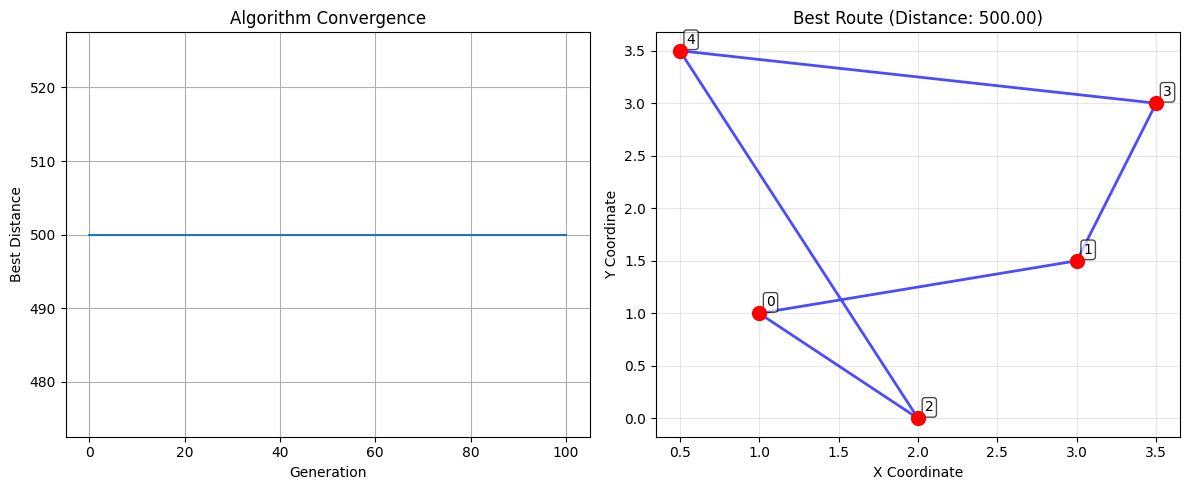

Creating animation...
Saving animation to tsp_evolution.gif...
Animation saved!


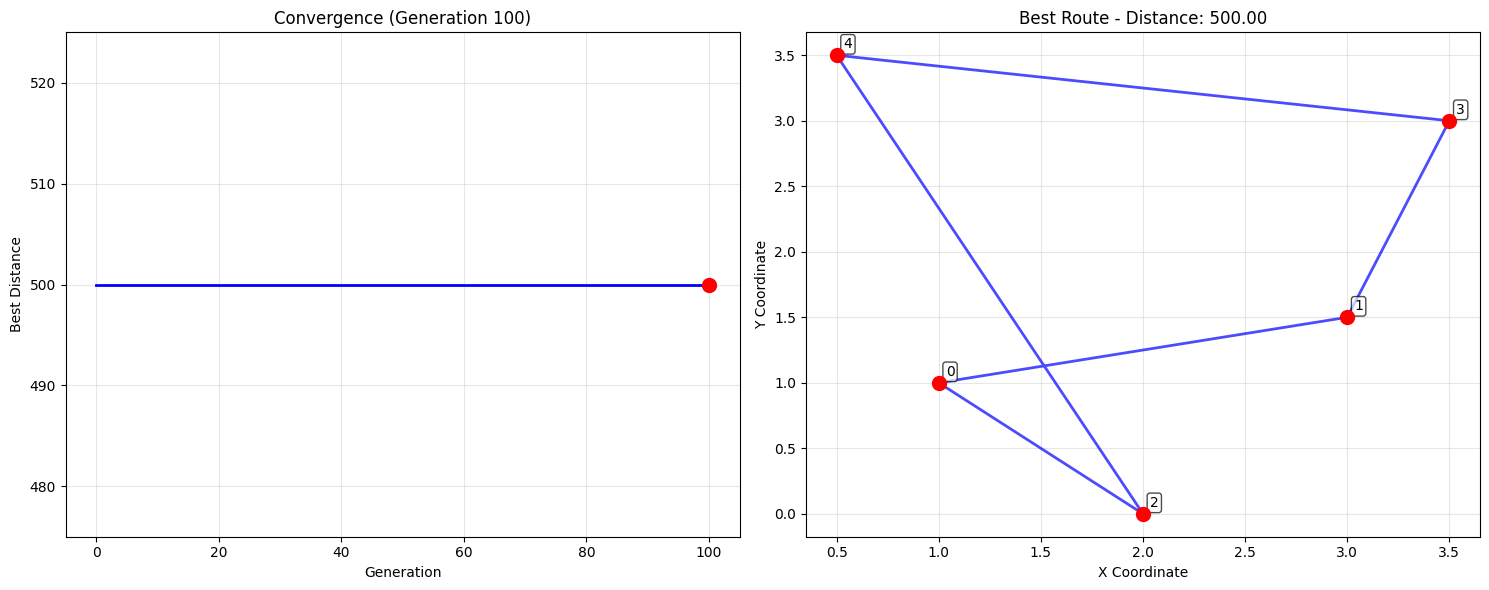

In [62]:
ga = TSPGeneticAlgorithm()
ga.run()

# Plot results
ga.plot_convergence()

# Create animation (uncomment to generate GIF)
ga.create_animation(interval=200, save_path='tsp_evolution.gif')